In [1]:
# Load the trained model
import pickle 
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset, load_metric
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd


2024-07-05 11:05:32.492118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 11:05:32.492239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 11:05:32.631852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
with open("/kaggle/input/12k-train-model/vit5_to_monot5_full_16k_train_2negative.pkl", 'rb') as f:
    model = pickle.load(f)
model.to('cuda')
model.eval()

tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [3]:
# Path to the csv file needed inefer
file_path = "/kaggle/input/all-private-test-related-data-alqac-2024/bm25_bert_len_output_data_private_24.csv"

public_test_df = pd.read_csv(file_path)

# public_test_df = public_test_df.iloc[0:400]
public_test_df.head(1)

,question_id,query,law_id,article_id,content,bm25_score,bm25_score_scaled,label,query_length,article_length,bert_score
0,04-DS-1,"Trong nguyên tắc về quản lý viên chức, việc tu...",Luật Viên chức,6,Các nguyên tắc quản lý viên chức 1. Bảo đảm sự...,91.59893,1.0,0,47,166,1.0


In [4]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["inputs"], max_length=1024, truncation=True, padding=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["labels"], max_length=10, truncation=True, padding=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [5]:
import pandas as pd 
from datasets import Dataset, load_metric


# Prepare your test data
input_lines = []
label_lines = []
data = []

for index, row in public_test_df.iterrows():
    query = row["query"]
    article_id = row["article_id"]
    document = row["content"]
    actual_label = "đúng" if row["label"] else "sai"

    input_lines.append(f"Câu hỏi: {query} Điều luật: Điều {article_id}. {document} Có liên quan:")
    label_lines.append(actual_label)
    data.append({"question": query, "document": document, "actual_label": actual_label})

# Create DataFrame
df = pd.DataFrame(data)

input_lines  = input_lines
label_lines = label_lines

dict_obj = {'inputs': input_lines, 'labels': label_lines}

dataset = Dataset.from_dict(dict_obj)
test_tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=10)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=10):   0%|          | 0/10000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword ar

In [6]:
bs = 32
dataloader = torch.utils.data.DataLoader(test_tokenized_datasets, collate_fn=data_collator, batch_size=bs)
max_target_length = 10

predictions = []
references = []

prob_of_token_true = []
most_likely_token_probss = []

model.eval()

for i, batch in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        b_size = len(batch['input_ids'])
        
        outputs = model.generate(
              input_ids=batch['input_ids'].to('cuda'),
              max_length=max_target_length,
              attention_mask=batch['attention_mask'].to('cuda'),
          )
        
        decoder_input_ids = torch.tensor([[1]] * b_size)  # Initialize decoder input IDs with a bos token (1)
        decoder_attention_mask = torch.tensor([[1]] * b_size)  # Initialize decoder attention mask
    
        logits = model(input_ids=batch['input_ids'].to('cuda'), 
                       attention_mask=batch['attention_mask'].to('cuda'), 
                       decoder_input_ids=decoder_input_ids.to('cuda'), 
                       decoder_attention_mask=decoder_attention_mask.to('cuda'))[0]
        probs_batch = torch.exp(torch.log_softmax(logits, dim=-1))

        # lưu prob của "đúng"
        prob_of_token_true.extend(probs_batch[:, 0, tokenizer.encode("đúng")].tolist())
        
        most_likely_token_index = torch.argmax(probs_batch, dim=-1)
        most_likely_token_probs = torch.max(probs_batch, dim=-1)[0]
        most_likely_token_probss.extend(most_likely_token_probs.tolist())        
        
        with tokenizer.as_target_tokenizer():
            outputs = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in outputs]
            labels = np.where(batch['labels'] != -100,  batch['labels'], tokenizer.pad_token_id)
            actuals = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in labels]
        predictions.extend(outputs)
        references.extend(actuals)


  0%|          | 0/313 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


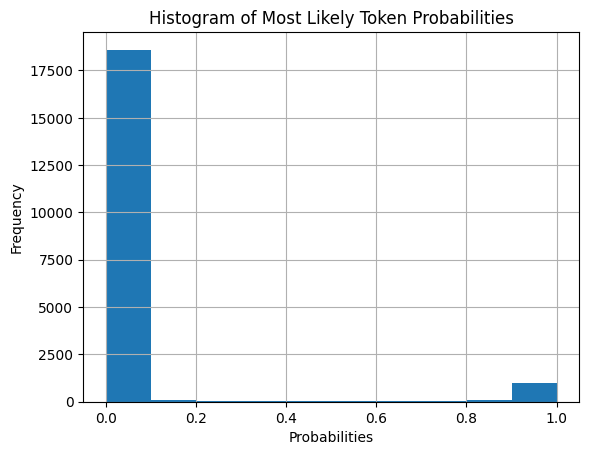

In [7]:
import matplotlib.pyplot as plt

# Chuyển đổi thành mảng numpy để dễ dàng tính toán
arr = np.array(prob_of_token_true)

# Lấy giá trị cần vẽ
values = arr.flatten()  # Làm phẳng mảng thành mảng 1 chiều

# Vẽ biểu đồ histogram
plt.hist(values, bins=10)  # Chia thành 10 bin
plt.xlabel('Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Most Likely Token Probabilities')
plt.grid(True)
plt.show()


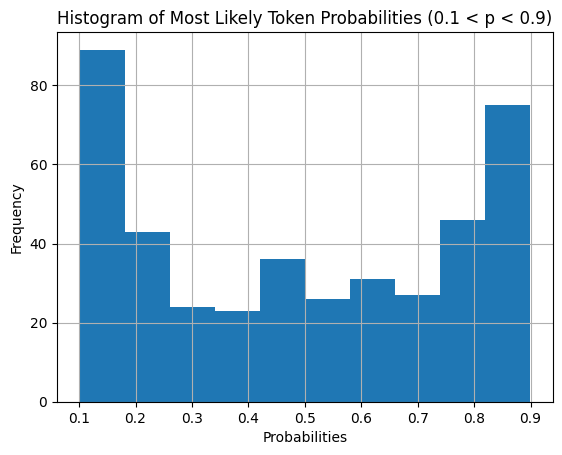

In [8]:
arr = np.array(prob_of_token_true)

# Lọc ra các giá trị nhỏ hơn 0.9
values = arr[arr < 0.9]
values = values[values > 0.1]

# Vẽ biểu đồ histogram
plt.hist(values, bins=10)  # Chia thành 10 bin
plt.xlabel('Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Most Likely Token Probabilities (0.1 < p < 0.9)')
plt.grid(True)
plt.show()

In [9]:
# Add predictions to DataFrame
public_test_df["ViMonoT5_score"] = prob_of_token_true
public_test_df["ViMonoT5_predict"] = [1 if value == "đúng" else 0 for value in predictions]
public_test_df

,question_id,query,law_id,article_id,content,bm25_score,bm25_score_scaled,label,query_length,article_length,bert_score,ViMonoT5_score,ViMonoT5_predict
0,04-DS-1,"Trong nguyên tắc về quản lý viên chức, việc tu...",Luật Viên chức,6,Các nguyên tắc quản lý viên chức 1. Bảo đảm sự...,91.598930,1.000000,0,47,166,1.000000e+00,"[0.9999246597290039, 2.242316776701614e-09]",1
1,04-DS-1,"Trong nguyên tắc về quản lý viên chức, việc tu...",Luật Viên chức,7,Vị trí việc làm 1. Vị trí việc làm là công việ...,70.130809,0.650504,0,47,98,2.494482e-05,"[0.9929566383361816, 1.869018895206409e-08]",1
2,04-DS-1,"Trong nguyên tắc về quản lý viên chức, việc tu...",Luật Viên chức,31,"Bổ nhiệm, thay đổi chức danh nghề nghiệp 1. Vi...",66.734567,0.595214,0,47,241,4.715467e-06,"[0.0014144058804959059, 2.0602182182472006e-09]",0
3,04-DS-1,"Trong nguyên tắc về quản lý viên chức, việc tu...",Luật Viên chức,37,Bổ nhiệm viên chức quản lý 1. Việc bổ nhiệm vi...,64.113004,0.552536,0,47,265,4.235992e-06,"[0.0005456755752675235, 7.735727058921782e-10]",0
4,04-DS-1,"Trong nguyên tắc về quản lý viên chức, việc tu...",Luật Viên chức,32,Thay đổi vị trí việc làm 1. Khi đơn vị sự nghi...,63.772650,0.546995,0,47,143,6.590268e-06,"[0.0015167994424700737, 3.832445916174265e-09]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,04-TL-9,Trong trường hợp từ chối cấp Giấy phép kinh do...,Luật Điện ảnh,9,Những nội dung và hành vi bị nghiêm cấm trong ...,18.312051,0.004261,0,28,643,3.051623e-08,"[0.000627951929345727, 1.026809193227507e-09]",0
9996,04-TL-9,Trong trường hợp từ chối cấp Giấy phép kinh do...,Luật Bảo vệ môi trường,111,Quan trắc nước thải 1. Đối tượng phải quan trắ...,18.303320,0.004092,0,28,465,2.339750e-06,"[4.984752013115212e-05, 9.077209123242724e-11]",0
9997,04-TL-9,Trong trường hợp từ chối cấp Giấy phép kinh do...,Luật Bảo vệ môi trường,40,Nội dung giấy phép môi trường 1. Nội dung giấy...,18.301100,0.004049,0,28,684,1.124336e-06,"[0.00010249685146845877, 1.8910592536336424e-10]",0
9998,04-TL-9,Trong trường hợp từ chối cấp Giấy phép kinh do...,"Luật Phòng, chống ma túy",27,Xác định tình trạng nghiện ma túy 1. Xác định ...,18.162389,0.001353,0,28,632,3.218948e-07,"[5.855123890796676e-05, 7.500237930724296e-11]",0


In [10]:
public_test_df.to_csv('bm25_bert_len_output_data_private_24_vimonot5.csv', index=False)